In [12]:
%run ./gates.ipynb

In [8]:
import math

In [61]:
ZERO = np.array([1, 0])
ONE  = np.array([0, 1])

ID2  = np.array([[1, 0],
                 [0, 1]])
O2   = np.array([[0, 0],
                 [0, 0]])

In [77]:
def kronify(no_of_bits, bit_component, default = ZERO):
    result = np.array([1])
    bit = 0
    while (bit < no_of_bits):
        component = bit_component.get(bit, default)
        result = np.kron(result, component)
        bit += int(math.log(component.shape[0], 2))
    return result

Mit `kronify` kann zum Beispiel der Zustandsvektor initialisiert werden.

In [18]:
kronify(3, {0: ONE}, ZERO)

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

Oder man setzt die Matrizen auf, die auf dem Zustandsvektor operieren wird.

In [21]:
kronify(3, {1: CNOT}, ID2)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

# Entwicklungsnotebook

Werkstatt, um Umsetzungen zum Quantenschaltungssimulator auszuprobieren.

In [54]:
import numpy as np
from cmath import isclose, phase, pi, sqrt
import math
import matplotlib.pyplot as plt

In [158]:
class QState:
    def __init__(self, no_of_bits, bit_state = {0: np.array([1, 0])}):
        self.no_of_bits = no_of_bits
        self.state = kronify(no_of_bits, bit_state, ZERO)
    
    def isvalid(self):
        return isclose(self.state @ np.conjugate(self.state), 1.0)
    
    def op(self, operator, bit = 0):
        self.state = kronify(self.no_of_bits, {bit: operator}, ID2) @ self.state
        return self

    def expect(self, query = {0: ZERO}):
        L = kronify(self.no_of_bits, query, ID2)
        return np.sum(L @ (np.conjugate(self.state) * self.state))

    def collapse(self, query = {0: ZERO}):
        L = kronify(self.no_of_bits, query, ID2)
        state = np.sum(L * self.state, axis=0)
        self.state = (1 / np.linalg.norm(state)) * state
        return self

    #def measure(self, bit, value = ONE):
    #    expectation = expect({bit: value})

        

In [169]:
# QState(2).op(H).show().expect({1: np.array([math.sqrt(1/100.0), 1/math.sqrt(99/100.0)])})
QState(2).op(H).show().collapse({1: ONE})

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%


/var/folders/0k/rm5kn55j7psf5txx4jbwzvjh0000gn/T/ipykernel_3508/3049918004.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  self.state = (1 / np.linalg.norm(state)) * state
/var/folders/0k/rm5kn55j7psf5txx4jbwzvjh0000gn/T/ipykernel_3508/3049918004.py:20: RuntimeWarning: invalid value encountered in multiply
  self.state = (1 / np.linalg.norm(state)) * state


QState(2) valid = False:
 0 |00⟩ nan (nan * e^nan°) nan%
 1 |01⟩ nan (nan * e^nan°) nan%
 2 |10⟩ nan (nan * e^nan°) nan%
 3 |11⟩ nan (nan * e^nan°) nan%

In [159]:
class QState(QState):
    def __repr__(self):
        repr = f"{self.__class__.__name__}({self.no_of_bits}) valid = {self.isvalid()}:"
        for i in range(0, self.state.shape[0]):
            num = self.state[i]
            repr += f"\n{i:2d} |{i:0{self.no_of_bits}b}⟩ "
            repr += f"{num.real if isclose(num.imag, 0.0) else (f'{num.imag}i' if isclose(num.real, 0.0) else f'{num.real} + {num.imag}i')} "
            repr += f"({abs(num):.4f} * e^{phase(num) / pi * 180.0:.2f}°) "
            repr += f"{abs(num * num):.2%}"
        return repr
    
    def show(self):
        print(self)
        return self
    
    def plot(self):
        names = list(map(lambda x: f'|{x}⟩', range(0, self.state.shape[0])))
        values = list(map(lambda x: abs(x), self.state * self.state))
        plt.bar(names, values)
        plt.suptitle(f'{self.__class__.__name__}({self.no_of_bits})')
        plt.show()
        return self

In [164]:
QState(3).show().collapse({0: ONE})

QState(3) valid = True:
 0 |000⟩ 1 (1.0000 * e^0.00°) 100.00%
 1 |001⟩ 0 (0.0000 * e^0.00°) 0.00%
 2 |010⟩ 0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 0 (0.0000 * e^0.00°) 0.00%
 4 |100⟩ 0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0 (0.0000 * e^0.00°) 0.00%


/var/folders/0k/rm5kn55j7psf5txx4jbwzvjh0000gn/T/ipykernel_3508/3049918004.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  self.state = (1 / np.linalg.norm(state)) * state
/var/folders/0k/rm5kn55j7psf5txx4jbwzvjh0000gn/T/ipykernel_3508/3049918004.py:20: RuntimeWarning: invalid value encountered in multiply
  self.state = (1 / np.linalg.norm(state)) * state


QState(3) valid = False:
 0 |000⟩ nan (nan * e^nan°) nan%
 1 |001⟩ nan (nan * e^nan°) nan%
 2 |010⟩ nan (nan * e^nan°) nan%
 3 |011⟩ nan (nan * e^nan°) nan%
 4 |100⟩ nan (nan * e^nan°) nan%
 5 |101⟩ nan (nan * e^nan°) nan%
 6 |110⟩ nan (nan * e^nan°) nan%
 7 |111⟩ nan (nan * e^nan°) nan%

Mit dieser Änderung von `__init__` kann ein Dictionary übergeben werden, das angibt, welches Qubit wie initialisiert werden soll. Per default wird jedes Qubit auf $|0\rangle$, d.h. `np.array([1, 0])` gesetzt. Der Kopf der Initialisierungsmethode zeigt beispielhaft, wie ein solches Dictionary aufgebaut ist. Die Zählung der Qubits beginnt bei 0.

In [271]:
class QState(QState):
    def __init__(self, n, qubitState = {0: np.array([1, 0])}):
        self.n = n
        self.state = np.array([1], dtype=complex)
        for qubit in range(0,n):
            self.state = np.kron(self.state, qubitState.get(qubit, np.array([1, 0])))

In [272]:
QState(3)

QState(3) valid = True:
 0 |000⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 1 |001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [273]:
QState(3, {1: np.array([0,1]), 2: np.array([0,1])})

QState(3) valid = True:
 0 |000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 1 |001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 4 |100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

Aufsetzen einiger Gates für die folgende Simulation.

## Expectations (Erwartungen)

Die Erwartung gibt an, mit welcher Wahrscheinlichkeit ein Qubit bzw. eine Reihe von Qubits an den gegebenen Positionen einen bestimmten Wert annehmen. Bei einem Qubit wird in der Regel die Wahrscheinlichkeit für $|0\rangle$ oder $|1\rangle$ als Erwartung angefragt, bei zwei Qubits eine Kombination aus $|0\rangle\,|0\rangle$, $|0\rangle\,|1\rangle$, $|1\rangle\,|0\rangle$ bzw. $|1\rangle\,|1\rangle$.

Das Skalarprodukt zweier Basisvektoren ist Null.

In [312]:
ZERO * ONE

array([0.+0.j, 0.+0.j])

## Measurement

In [317]:
from numpy.random import default_rng
rng = default_rng()
val = rng.uniform(0, 1)
val

0.19945621773927957

In [ ]:
def measure(qubit, basisA = ZERO, basisB = ONE):
    rng = default_rng()
    prob = self.expect({qubit: basisA});
    measured = basisA if rng.uniform(0, 1) <= prob else basisB
     

## Simulation

In [279]:
from cmath import sqrt

In [280]:
q = QState(4, {0: np.array([1/sqrt(2), 1/sqrt(2)]),
               1: np.array([1/sqrt(2), 1/sqrt(2)])})
#q = QState(4)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [281]:
q = q.op(PAULIX, 0).op(PAULIX, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [282]:
q = q.op(SWAP, 1).op(CNOT).op(SWAP, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [283]:
q = q.op(CNOT, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
13 |1101⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%


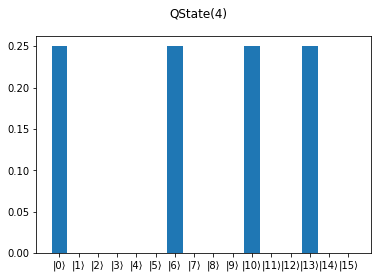

In [284]:
q = q.op(SWAP, 2).op(TOFFOLI).op(SWAP, 2).show().plot()

In [306]:
print(q.expect({2: ZERO, 3: ZERO})) # 25%
print(q.expect({2: ZERO, 3: ONE}))  # 25%
print(q.expect({2: ONE, 3: ZERO}))  # 50%
print(q.expect({2: ONE, 3: ONE}))   #  0%
print(q.expect({2: ZERO})) # 50%
print(q.expect({2: ONE}))  # 50%
print(q.expect({3: ZERO})) # 75%
print(q.expect({3: ONE}))  # 25%

(0.2499999999999999+0j)
(0.2499999999999999+0j)
(0.4999999999999998+0j)
0j
(0.4999999999999998+0j)
(0.4999999999999998+0j)
(0.7499999999999997+0j)
(0.2499999999999999+0j)


Beachte: Aus der Erwartung an die Einzelbits ist nicht so einfach die Erwartung an die Kombination von Bits zu berechnen. Eine Messung verändert den Zustandsvektor, was die zweite Messung beeinflusst. Das ist zwar kommutativ, aber den Erwartungen nicht als Kombination anzusehen.